In [11]:
# Kütüphaneleri yükleme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import classification_report

In [12]:
# Stil ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [13]:
df = pd.read_csv("chess_data.csv")

# Başlamamış satranç maçlarını status sütunundan çıkarıyoruz
df = df[df['status'] != 'noStart']

# Kullanacağımız sütunlardaki NaN değerleri atıyoruz
df = df.dropna(subset=['white_rating', 'black_rating', 'winner', 'pgn', 'time_control'])

# Kullanılacak veri sayısını belirleme
df = df.sample(n=25000, random_state=42)

print(df.head())

         game_id        white  white_rating                 black  \
165724  rwQZcxed  winchessa39        2131.0  kingscrusher-youtube   
84581   prDMH64v  dark-priest        2498.0               shnitez   
77915   B5cAsCQh      shnitez        2365.0             chewychew   
239928  ntjezo3p   johnmadden        2240.0  kingscrusher-youtube   
327308  kIVA5IcN      benbank        1500.0             lance5500   

        black_rating winner     status  time_control  incriment  \
165724        2469.0  black       mate          60.0        0.0   
84581         2537.0  black     resign          60.0        0.0   
77915         1691.0  white       mate         600.0        0.0   
239928        2429.0  black  outoftime          30.0        0.0   
327308        2645.0  black     resign         300.0        5.0   

                                                      pgn  
165724  e4 Nxc3 bxc3 Bg7 Be3 c5 Nf3 O-O Be2 Nc6 Rc1 Qc...  
84581   Nf3 g6 d3 Bg7 Nbd2 Nf6 e4 O-O Be2 d6 O-O c5 c3...  
77

In [14]:

# pgn sütunundan sadece ilk hamleyi çekiyoruz
def simplify_opening(pgn):
    moves = pgn.strip().split()
    return moves[0] if len(moves) > 0 else "Unknown"

df["Opening"] = df["pgn"].apply(simplify_opening)

print(df[["Opening"]].head())

       Opening
165724      e4
84581      Nf3
77915       e4
239928     Nf3
327308      e4


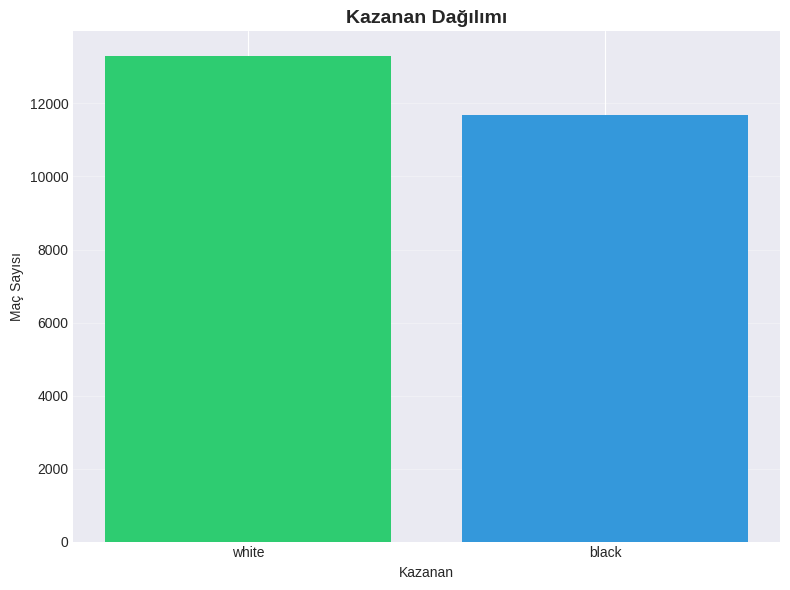

In [15]:
# ========== VERİ GÖRSELLEŞTİRME ==========
# 1. Kazanan Dağılımı
plt.figure(figsize=(8, 6))
winner_counts = df['winner'].value_counts()
plt.bar(winner_counts.index, winner_counts.values, color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Kazanan Dağılımı', fontsize=14, fontweight='bold')
plt.xlabel('Kazanan')
plt.ylabel('Maç Sayısı')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

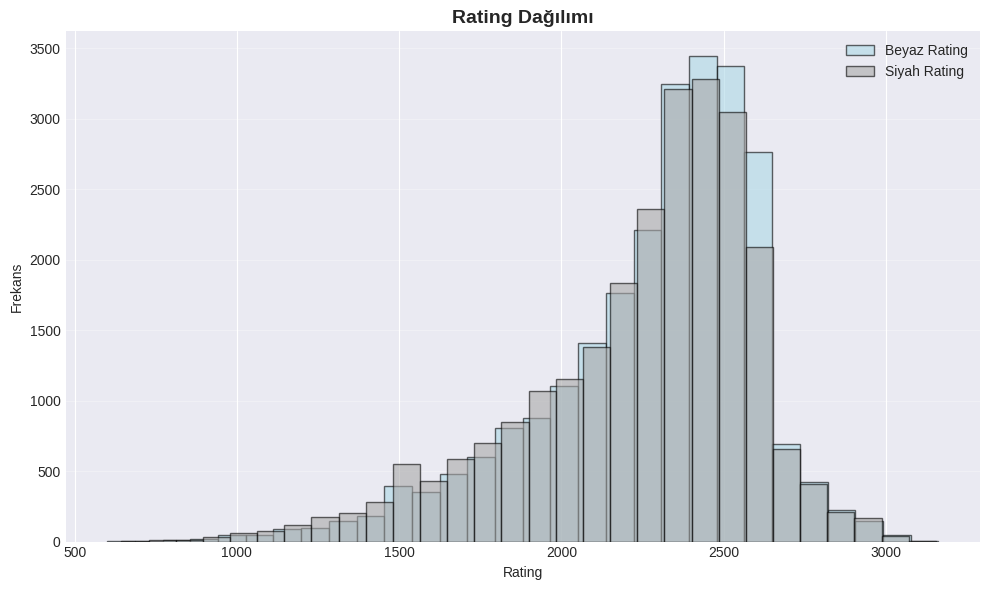

In [16]:
# 2. Rating Dağılımı
plt.figure(figsize=(10, 6))
plt.hist(df['white_rating'], bins=30, alpha=0.6, label='Beyaz Rating', color='lightblue', edgecolor='black')
plt.hist(df['black_rating'], bins=30, alpha=0.6, label='Siyah Rating', color='darkgray', edgecolor='black')
plt.title('Rating Dağılımı', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Frekans')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

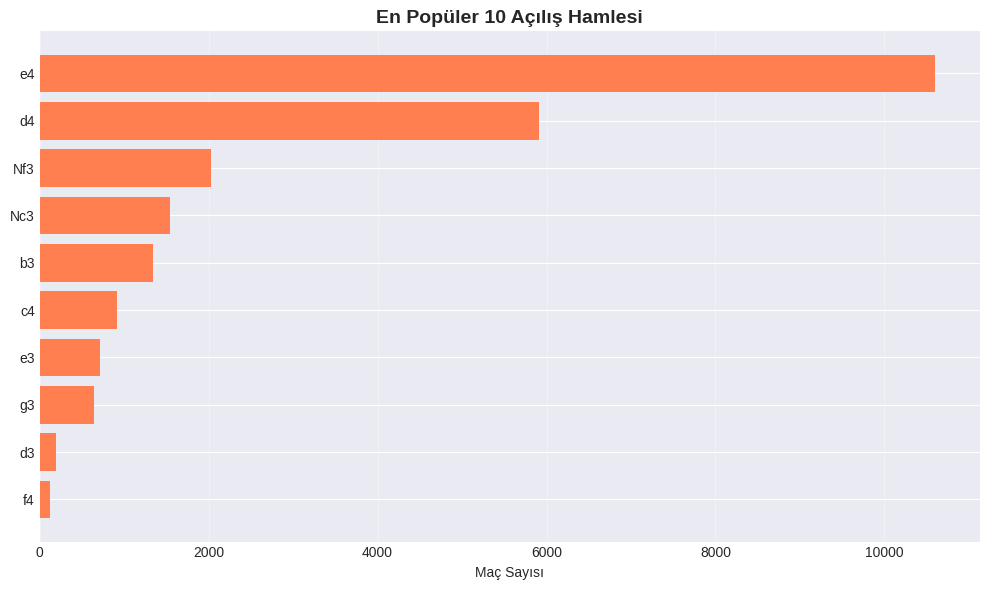

In [17]:

# 3. En Popüler Açılışlar
plt.figure(figsize=(10, 6))
opening_counts = df['Opening'].value_counts().head(10)
plt.barh(opening_counts.index, opening_counts.values, color='coral')
plt.title('En Popüler 10 Açılış Hamlesi', fontsize=14, fontweight='bold')
plt.xlabel('Maç Sayısı')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# ========== MODEL EĞİTİMİ ==========

features = ["white_rating", "black_rating", "time_control", "Opening"]
target = "winner"

X = df[features].copy()
y = df[target].copy()

X = X.dropna()
y = y.loc[X.index]

# Label Encoding
le_time = LabelEncoder()
X["time_control"] = le_time.fit_transform(X["time_control"].astype(str))

le_opening = LabelEncoder()
X["Opening"] = le_opening.fit_transform(X["Opening"].astype(str))

le_y = LabelEncoder()
y = le_y.fit_transform(y)

print("Encoded classes:", le_y.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Logistic Regression modeli
model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Encoded classes: ['black' 'white']



Accuracy: 0.8078

Classification Report:
               precision    recall  f1-score   support

       black       0.81      0.77      0.79      2341
       white       0.80      0.85      0.82      2659

    accuracy                           0.81      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.81      0.81      0.81      5000



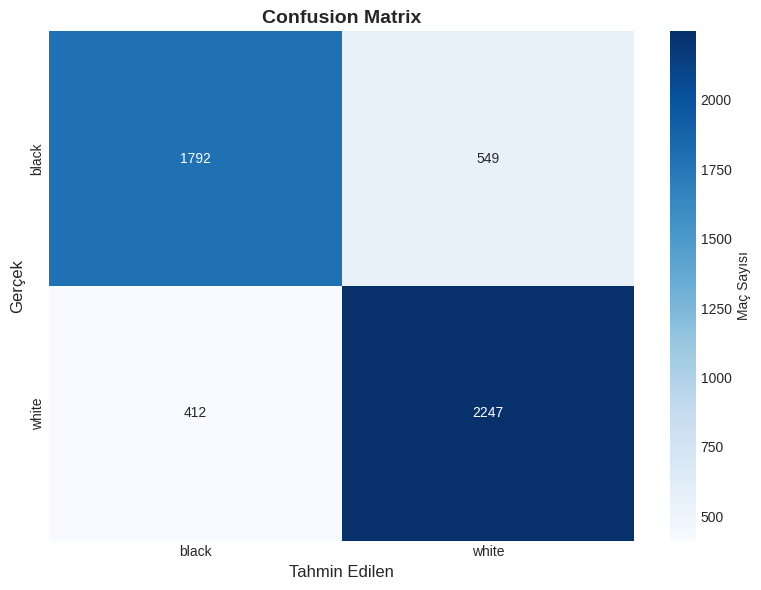

In [21]:
# ========== PERFORMANS GÖRSELLEŞTİRME ==========

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_y.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_,
            yticklabels=le_y.classes_,
            cbar_kws={'label': 'Maç Sayısı'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Tahmin Edilen', fontsize=12)
plt.ylabel('Gerçek', fontsize=12)
plt.tight_layout()
plt.show()

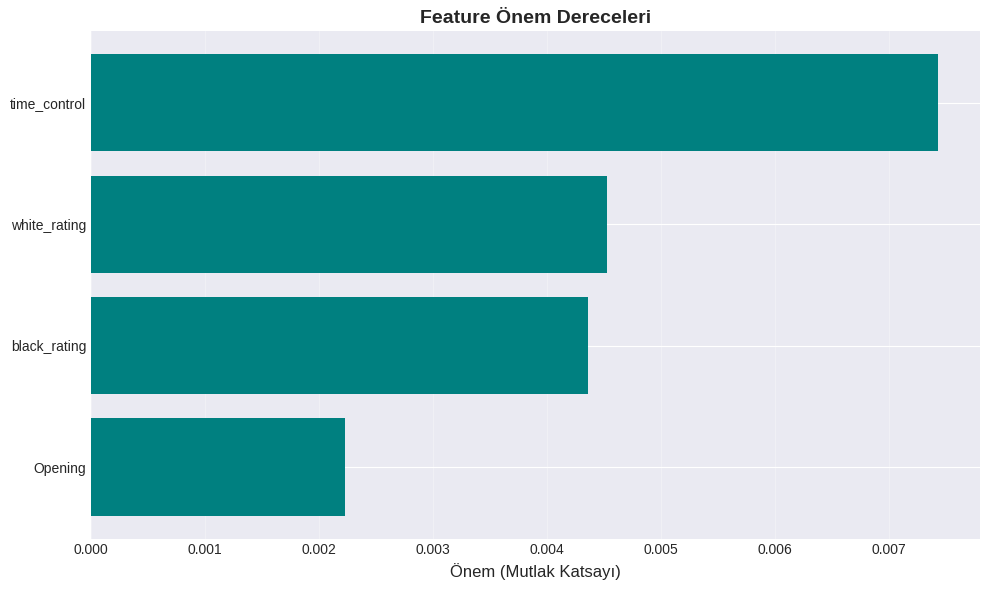

In [22]:

# Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(model.coef_[0])
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='teal')
plt.xlabel('Önem (Mutlak Katsayı)', fontsize=12)
plt.title('Feature Önem Dereceleri', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

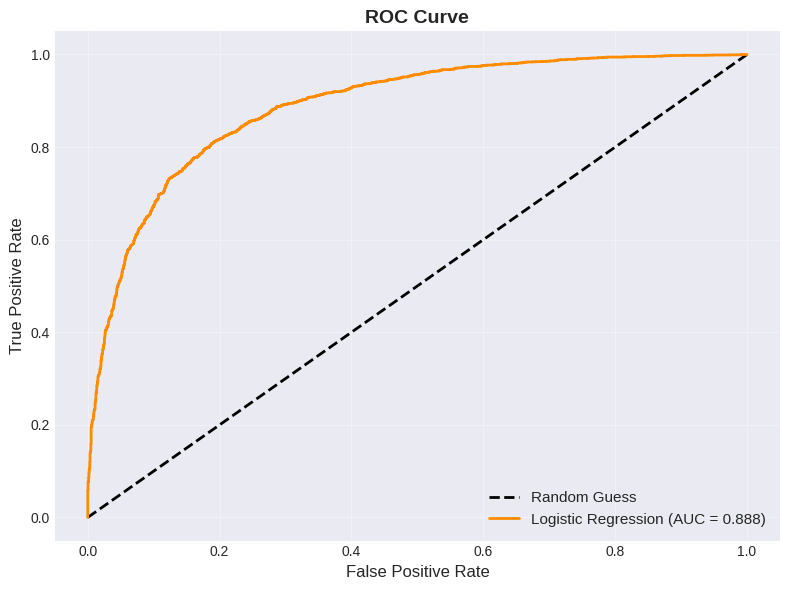


AUC Score: 0.8880

Tüm analizler tamamlandı!


In [25]:
# ROC Curve (Binary ise)
if len(le_y.classes_) == 2:
    y_scores = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
    auc = roc_auc_score(y_test, y_scores[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=2)
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.3f})', linewidth=2, color='darkorange')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nAUC Score: {auc:.4f}")
else:
    print("\nROC yalnızca 2 sınıflı veride hesaplanır.")

    # Multi-class için alternatif: sınıf bazlı accuracy
    report_dict = classification_report(y_test, y_pred, target_names=le_y.classes_, output_dict=True)

    classes = le_y.classes_
    f1_scores = [report_dict[c]['f1-score'] for c in classes]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, f1_scores, color=['#2ecc71', '#3498db', '#e74c3c'])
    plt.xlabel('Sınıf', fontsize=12)
    plt.ylabel('F1-Score', fontsize=12)
    plt.title('Sınıf Bazlı F1-Score', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nTüm analizler tamamlandı!")